In [1]:
from theano.sandbox import cuda
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1596' (I am process '1639')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [2]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir
path = DATA_HOME_DIR + '/data/'

sample_path = path + '/sample/'
train_path = path + '/train/'
valid_path = path + '/valid/'
batch_size=64

(val_classes, trn_classes, test_classes, val_labels, trn_labels, test_labels,
    val_filenames, filenames, test_filenames) = get_classes(sample_path)

raw_val_filenames = [f.split('/')[-1] for f in val_filenames]
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]

Found 2984 images belonging to 8 classes.
Found 394 images belonging to 8 classes.
Found 399 images belonging to 8 classes.


In [3]:
# load raw image saved in disk
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')
test = load_array(path+'results/test.dat')

## put bounding box upon images

In [8]:
import ujson as json
# bounding box dict
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}
test_file2idx = {o:i for i,o in enumerate(raw_test_filenames)}


empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_test_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
        
# image sizes
sizes = [PIL.Image.open(path+'sample/train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'sample/valid/'+f).size for f in val_filenames]
raw_test_sizes = [PIL.Image.open(path+'sample/test/'+f).size for f in test_filenames]

# adjust bounding box to resized image
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)
test_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_test_filenames, raw_test_sizes)]).astype(np.float32)

### precompute vgg conv layers, then just load them when needed
### since we are not going to finetune them

In [13]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

# load precomputed vgg weights
model.load_weights(path+'results/ft1.h5')
# extract conv layers
conv_layers,fc_layers = split_at(model, Convolution2D)
# load precomputed vgg conv features
conv_trn_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
conv_test_feat = load_array(path+'results/conv_test_feat.dat')
conv_val_feat.shape

(394, 512, 14, 14)

## construct multiple output model

In [14]:
p=0.6

In [60]:
import numpy as np 
np.random.seed(233) 
# fit shuffle false

In [80]:
# from fastai
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [61]:
# full conv models
inp = Input(conv_layers[-1].output_shape[1:])
x = BatchNormalization(axis=1, input_shape=(512,14,14))(inp)
x = Convolution2D(128,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)
x = Convolution2D(128,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)
x = Convolution2D(128,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x_b = Convolution2D(4,3,3, border_mode='same')(x)
x_bb = GlobalAveragePooling2D(name='bb')(x_b)
x_c = Convolution2D(8,3,3, border_mode='same')(x)
x_c = GlobalAveragePooling2D()(x_c)
x_class = Activation('softmax', name = 'class')(x_c)

Couldn't import dot_parser, loading of dot files will not be possible.


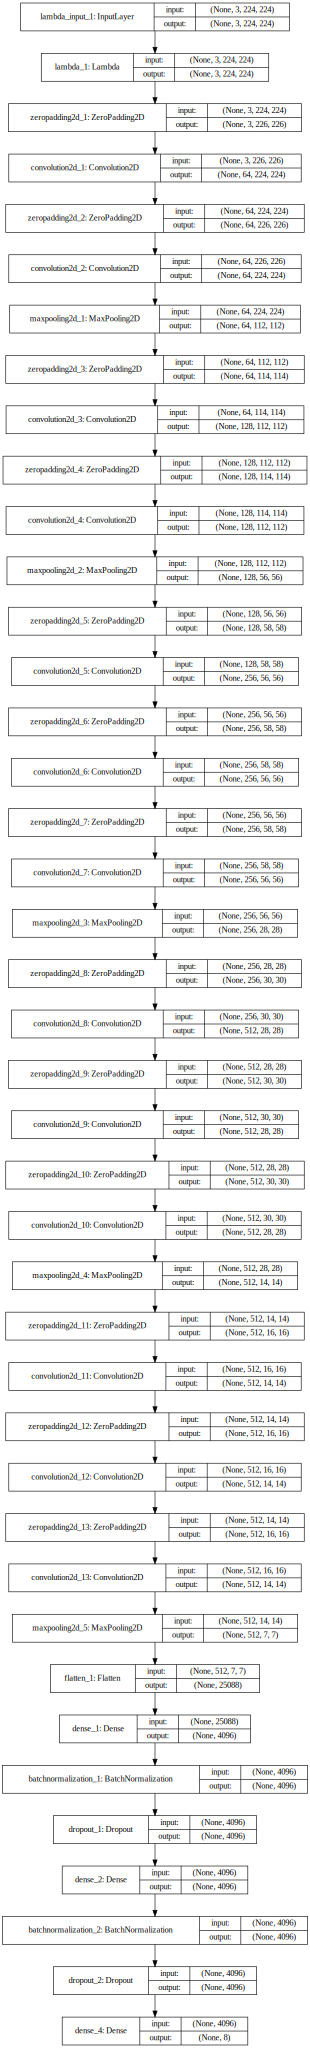

In [36]:
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
# plot(model, to_file='model_final.png', show_shapes=True)

In [25]:
from keras.callbacks import History 
history = History()

In [81]:
class_acc=[]
val_class_acc=[]
class_loss=[]
val_class_loss=[]

In [82]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [94]:
model.optimizer.lr = 1e-6
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]), callbacks=[history] )

Train on 2984 samples, validate on 394 samples
Epoch 1/10
2984/2984 [==============================] - 2s - loss: 0.4702 - bb_loss: 455.3510 - class_loss: 0.0149 - bb_acc: 0.6267 - class_acc: 0.9956 - val_loss: 1.2420 - val_bb_loss: 988.6073 - val_class_loss: 0.2534 - val_bb_acc: 0.4721 - val_class_acc: 0.9797
Epoch 2/10
2984/2984 [==============================] - 2s - loss: 0.4702 - bb_loss: 439.4257 - class_loss: 0.0308 - bb_acc: 0.6186 - class_acc: 0.9923 - val_loss: 1.3039 - val_bb_loss: 1033.8853 - val_class_loss: 0.2701 - val_bb_acc: 0.4569 - val_class_acc: 0.9746
Epoch 3/10
2984/2984 [==============================] - 2s - loss: 0.4542 - bb_loss: 433.4076 - class_loss: 0.0207 - bb_acc: 0.6277 - class_acc: 0.9953 - val_loss: 1.3091 - val_bb_loss: 1016.5926 - val_class_loss: 0.2925 - val_bb_acc: 0.4492 - val_class_acc: 0.9797
Epoch 4/10
2984/2984 [==============================] - 2s - loss: 0.4630 - bb_loss: 426.3258 - class_loss: 0.0367 - bb_acc: 0.6310 - class_acc: 0.9896 - va

In [95]:
history_list = history.history
class_acc += history_list['class_acc']
val_class_acc += history_list['val_class_acc']
class_loss += history_list['class_loss']
val_class_loss += history_list['val_class_loss']
len(class_acc)

50

In [96]:
model.evaluate(conv_test_feat, [test_bbox, test_labels])

384/399 [===========================>..] - ETA: 0s

[1.4235479752521467,
 1045.1966852556195,
 0.37835124335154779,
 0.46365914786967416,
 0.96240601503759393]

In [77]:
class_acc_percent = []
for i in class_acc:
    i = i * 100
    class_acc_percent.append(i)
    
val_class_acc_percent = []
for i in val_class_acc:
    i = i * 100
    val_class_acc_percent.append(i)

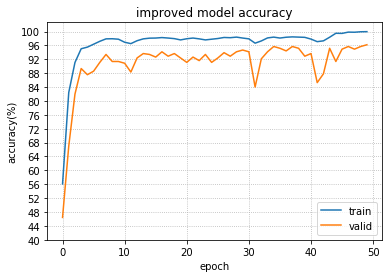

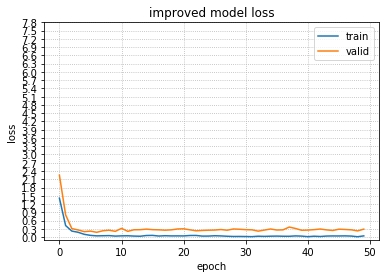

In [97]:
# summarize history for accuracy
plt.plot(class_acc_percent)
plt.plot(val_class_acc_percent)
plt.title('improved model accuracy')
plt.ylabel('accuracy(%)')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.grid(ls=":")
plt.yticks(np.arange(40, 104, 4))
plt.show()
# summarize history for loss
plt.plot(class_loss)
plt.plot(val_class_loss)
plt.title('improved model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(ls=":")
plt.yticks(np.arange(0, 8, 0.3))
plt.show()